## Locate Overlap Pixel to Mosaic Datacubes

This function locates overlapped pixels to help mosaic dithered exposures of the same source obtained under the same settings.<br /> <br />
This is a helper method for Professor Rupke's code **ifsr_mosaic**, which can be found at:
https://github.com/drupke/ifsred/blob/master/common/ifsr_mosaic.pro <br /><br />
The routine, as default, uses the brightest pixel to account for the shifts. However, in cases where that pixel isn't fully captured, this method could help locate another shared pixel to indicate the dithering.

In [1]:
from astropy.wcs import WCS
import astropy.io.fits as fits
from pylab import *
import matplotlib.patches as patches
import numpy as np
import random

In [2]:
# Function: mosaic_vis
# ----------------------------------------------------------------------------------------
# This method locates overlapped pixels to help mosaic dithered exposures. It also makes a 
# plot in wcs(deg) to help visualize the location of each frame and how they overlap. 
# ----------------------------------------------------------------------------------------
# Call:
#    out = mosaic_vis(datacubes)
# ----------------------------------------------------------------------------------------
# Inputs:
#   datacubes    String List    List of paths to the datacubes to be mosaiced
# ----------------------------------------------------------------------------------------
# Outputs:
#   out          Structure      The out structure contains 
#                           (1). out.wcs_info[0][:,:,i]:  range in wcs(deg) for datacube i
#                           (2). out.overlap[0]:          range in wcs(deg) of the overlap region
#                           (3). out.pix_loc[0]:          central pixel of the overlap region
# ----------------------------------------------------------------------------------------
# Notes:
# 1. The pixel location returned is by default the central pixel of the overlapped region
# 2. If the pixel location looks wierd, check the overlap region either in the plot or in out.overlap
#    to make sure that there exists an overlap region.
# ----------------------------------------------------------------------------------------
# Updates: 
#    Apr 6, 2021  W.Ning  Created.
# ----------------------------------------------------------------------------------------

def mosaic_vis(datacubes):
    num = np.shape(datacubes)[0]
    wcs_info = np.zeros((2,2,num))
    color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(num)]
    overlap_x = [360,0]
    overlap_y = [-90,90]
    pix = np.zeros((num,2))
    out = np.recarray((1,),dtype=[('wcs_info','O'),('overlap','O'),('pix_loc','O')])
    
    # Convert pixel location to wcs
    for i in np.arange(num):
        hdr = fits.getheader(datacubes[i])
        w = WCS(hdr)
        pix_x_tot = hdr['NAXIS2']
        pix_y_tot = hdr['NAXIS1']
        sky_x_start,sky_y_start,wav = w.pixel_to_world_values(0,0,1)
        sky_x_end,sky_y_end,_ = w.pixel_to_world_values(pix_y_tot-1,pix_x_tot-1,1)
        wcs_info[0,:,i] = [float(sky_x_start),float(sky_y_start)]
        wcs_info[1,:,i] = [float(sky_x_end),float(sky_y_end)]
        
        # Find overlap
        overlap_x = [np.min([overlap_x[0],float(sky_x_start)]),np.max([overlap_x[1],float(sky_x_end)])]
        overlap_y = [np.max([overlap_y[0],float(sky_y_start)]),np.min([overlap_y[1],float(sky_y_end)])]
        
    # Overlap
    overlap = np.zeros((2,2))
    overlap[0] = overlap_x
    overlap[1] = overlap_y
    
    # Pixel to mosaic
    for i in np.arange(num):
        hdr = fits.getheader(datacubes[i])
        w = WCS(hdr)
        loc = w.world_to_pixel_values(np.mean(overlap_x),np.mean(overlap_y),wav)
        pix[i] = [float(loc[1]),float(loc[0])]
    
    wcs_x_min = np.min(wcs_info[:,0,:])
    wcs_x_max = np.max(wcs_info[:,0,:])
    wcs_y_min = np.min(wcs_info[:,1,:])
    wcs_y_max = np.max(wcs_info[:,1,:])
    
    wcs_arr_x = np.linspace(wcs_x_min,wcs_x_max)
    wcs_arr_y = np.linspace(wcs_y_min,wcs_y_max)
    
    # Plot demo
    fig,ax = plt.subplots(figsize = (16,16))
    ax.plot(wcs_arr_x,wcs_arr_y,alpha=0)
    ax.set_xlabel('ra',fontsize=14)
    ax.set_ylabel('dec',fontsize=14)
    ax.set_xlim(ax.get_xlim()[::-1])
    ax.set_title('WCS Location Demo',fontsize=18)
    
    for i in np.arange(num):
        width = wcs_info[1,0,i]-wcs_info[0,0,i]
        height = wcs_info[1,1,i]-wcs_info[0,1,i]
        #rec = patches.Rectangle(((wcs_info[0,0,i]-wcs_x_min)*scale,(wcs_info[0,1,i]-wcs_y_min)*scale),
        #                       width*scale,height*scale,angle=0)
        rec = patches.Rectangle((wcs_info[0,0,i],wcs_info[0,1,i]),width,height,angle=0,zorder=2,
                                label='frame_{}'.format(i+1),color=color[i],alpha=0.5)
        label='frame_{}'.format(i+1)
        ax.add_patch(rec)
        ax.annotate(label,xy=(wcs_info[0,0,i]+0.45*width,wcs_info[0,1,i]+0.5*height),fontsize=14)
    
    rec = patches.Rectangle((overlap_x[0],overlap_y[0]),overlap_x[1]-overlap_x[0],overlap_y[1]-overlap_y[0],angle=0,
                           zorder=2, label = 'overlap', color='crimson',alpha=1)
    ax.add_patch(rec)
    
    ax.legend(loc='upper left',fontsize=14)
    
    out.wcs_info[0] = wcs_info; out.overlap[0] = overlap; out.pix_loc[0] = pix;
        
    return out

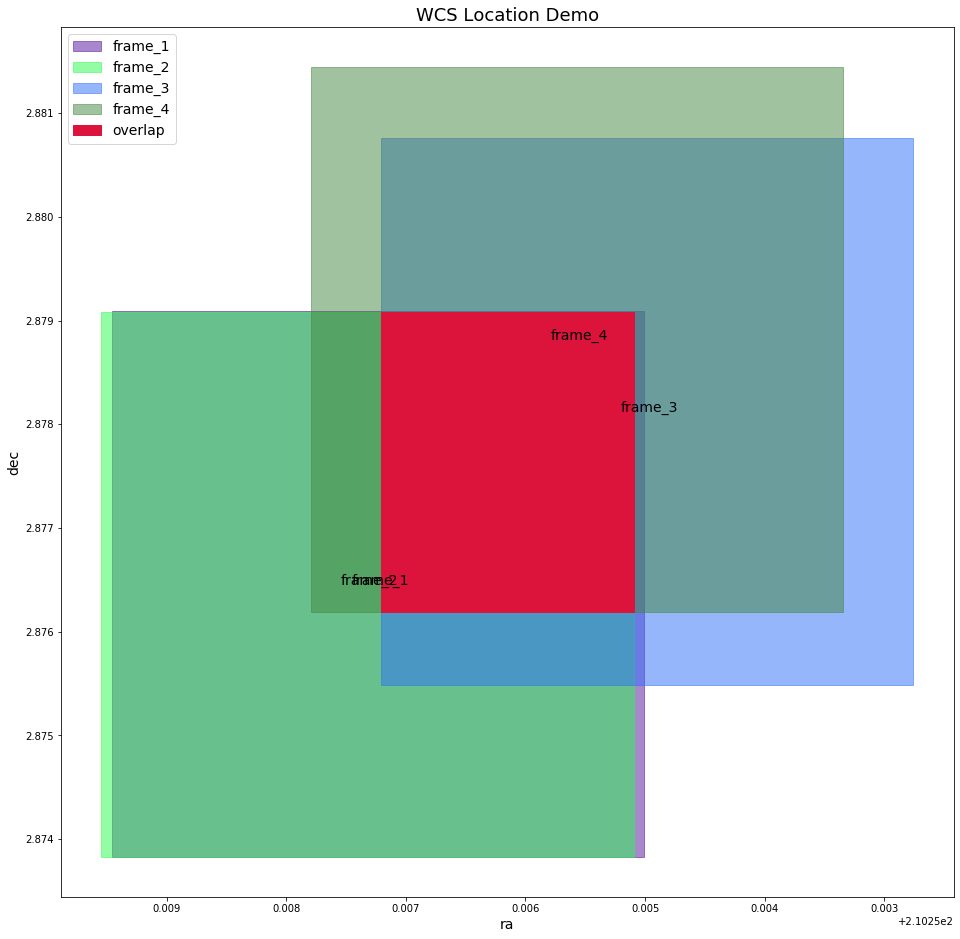

In [3]:
out = mosaic_vis(["abell_1.fits","abell_2.fits","abell_3.fits","abell_4.fits"])

In [4]:
# This records the range in wcs(deg) of each datacube
out.wcs_info[0]

array([[[210.25945888, 210.25954431, 210.25720748, 210.25779362],
        [  2.87382473,   2.87382636,   2.87549031,   2.87618692]],

       [[210.25500977, 210.25509245, 210.25276021, 210.25334266],
        [  2.87909074,   2.87908694,   2.88075994,   2.88144932]]])

In [5]:
# This records the overlap range in wcs(deg) of all the exposures
np.mean(out.overlap[0][0])

210.25614996315556

In [6]:
# This records the central pixel of the overlap region in each datacube
out.pix_loc[0]

array([[47.05428068, 40.9045136 ],
       [47.08446757, 41.9355286 ],
       [26.49335235, 13.08621352],
       [17.91018226, 20.31050072]])